In this notebook, we investigate if invariant manifolds can be determined entirely computationally (instead of having to go through tedious algebra and series expansions).

Our procedure will be as follows: define the system, compute the Jacobian at a fixed point, find its eigenvectors, select a series of initial conditions along eigenvectors corresponding to an invariant manifold, simulate their trajectories, then add some noise and give it to PySINDy with a polynomial basis.

Let's first try this with the version of the Lorenz system used in the course's homeworks, with $r=1$.

Eigenvalues: [-11.           0.          -2.66666667]
Center Eigenvector: [-0.70710678 -0.70710678  0.        ]


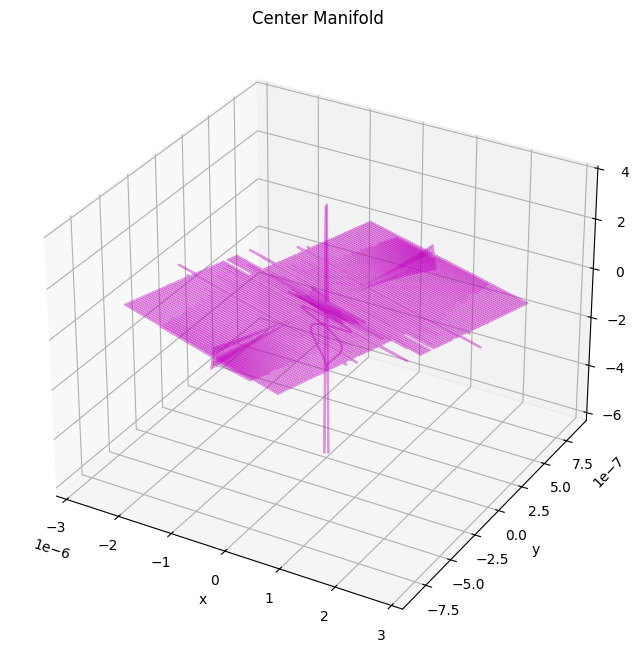

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pysindy as ps

# specific case of Lorenz system
def lorenz(t, xyz, sigma=10, beta=8/3, r=1):
    x, y, z = xyz
    dxdt = sigma * (y - x)
    dydt = r * x - y - x * z
    dzdt = -beta * z + x * y
    return [dxdt, dydt, dzdt]

# Jacobian for this system at origin
J = np.array([
        [-10, 10, 0],
        [1, -1, 0],
        [0, 0, -8/3]])

eigvals, eigvecs = np.linalg.eig(J)
print("Eigenvalues:", eigvals)

# let's find the center manifold
v_center = np.real(eigvecs[:, np.argmin(np.abs(eigvals))])
print("Center Eigenvector:", v_center)

# Generate initial conditions along the center eigenvector
deltas = np.linspace(-1e-6, 1e-6, 100)
initial_conditions = [delta * v_center for delta in deltas]

# Simulate trajectories from those initial conditions
t_span = (0, 20)
dt = 0.001
t_eval = np.arange(t_span[0], t_span[1], dt)

trajectories = []
for ic in initial_conditions:
    sol = solve_ivp(lorenz, t_span, ic, t_eval=t_eval, method='RK45')
    trajectories.append(sol.y.T)
# now trajectories is a list of 100 numpy arrays (since we plotted trajectories from 100 initial conditions)
# each with shape (total number of timesteps, 3), 3 being the dimensionality of the system

# Plot the trajectories
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
for traj in trajectories:
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='m', alpha=0.4)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Center Manifold')
plt.show()

In [8]:
# Fit polynomial SINDy
poly_lib = ps.PolynomialLibrary(degree=7)
optimizer = ps.STLSQ(threshold=1e-99)
model = ps.SINDy(feature_library=poly_lib, optimizer=optimizer)
model.fit(trajectories, t=dt, multiple_trajectories=True)
model.print()

(x0)' = 0.046 x0 + 0.015 x1
(x1)' = -0.005 x0 + -0.001 x1
(x2)' = 0.030 x2


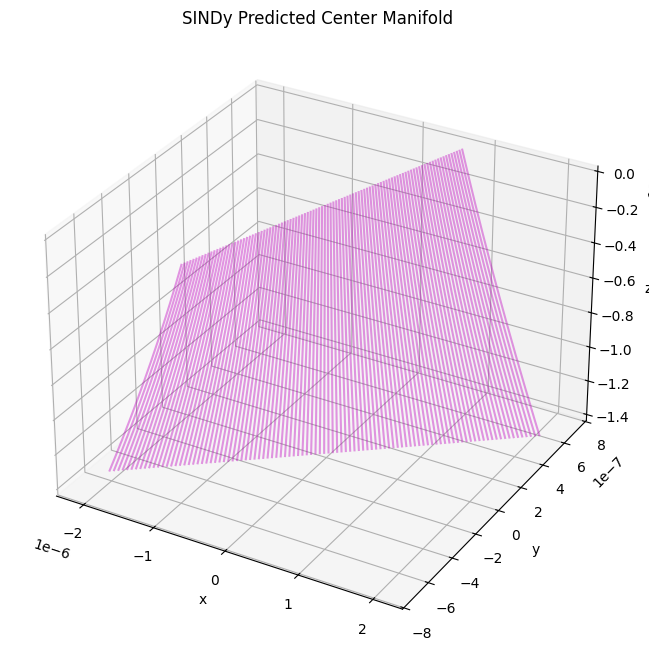

In [9]:
# Plot SINDy's predicted center manifold
sindy_trajecs = [model.simulate(ic, t_eval) for ic in initial_conditions]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
for traj in sindy_trajecs:
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='m', alpha=0.4)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('SINDy Predicted Center Manifold')
plt.show()